In [1]:
import numpy as np
import pandas as pd, re, requests
from itertools import combinations
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [3]:
# short preprocess
dataset_dir = '../../mimic-4/physionet.org/files/mimiciv/3.1/'
df = pd.read_csv(os.path.join(dataset_dir, "hosp/diagnoses_icd.csv"))
admissions = pd.read_csv(os.path.join(dataset_dir, "hosp/admissions.csv"))
df = pd.merge(
    df,
    admissions[['hadm_id', 'admittime', 'dischtime', 'deathtime']],
    on='hadm_id'
)

df[df['icd_version']==9].head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,deathtime
0,10000032,22595853,1,5723,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN
1,10000032,22595853,2,78959,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN
2,10000032,22595853,3,5715,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN
3,10000032,22595853,4,07070,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN
4,10000032,22595853,5,496,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN


In [4]:
df[df['icd_version']==9][['icd_code', 'icd_version']][:30]

,icd_code,icd_version
0,5723,9
1,78959,9
2,5715,9
3,07070,9
4,496,9
5,29680,9
6,30981,9
7,V1582,9
8,07071,9
9,78959,9


In [5]:
URL_GEM = "https://data.nber.org/gem/icd9toicd10cmgem.csv"

gem = pd.read_csv(URL_GEM, dtype=str).rename(columns=str.lower)

def norm(code):
    if pd.isna(code):
        return None
    code = re.sub(r'[\s\.]', '', str(code).upper())
    if code.isdigit() and len(code) < 3:
        code = code.zfill(3)
    return code

gem["icd9_norm"]  = gem["icd9cm"].apply(norm)
gem["icd10_norm"] = gem["icd10cm"].apply(norm)
gem["flags"]      = gem["flags"].astype(str)

gem_ok = gem[~gem["flags"].str[0].eq("7")]     
gem_ok["rank"] = gem_ok["flags"].str[0].astype(int)   

gem_ok = gem_ok.sort_values(["icd9_norm", "rank"])

MAP_9to10 = (
    gem_ok.groupby("icd9_norm")["icd10_norm"]
          .first()
          .to_dict()
)

def icd9_to_icd10_fuzzy(icd9, mapping):
    if icd9 in mapping:
        return mapping[icd9]

    code = icd9
    while len(code) < 5:
        code += "0"
        if code in mapping:
            return mapping[code]

    desc = {k: v for k, v in mapping.items() if k.startswith(icd9)}
    if desc:
        for k in sorted(desc):
            if k.endswith("0"):
                return desc[k]
        return next(iter(desc.values()))
    return None


df["icd_code_norm"] = df["icd_code"].apply(norm)

def map_row(row):
    if row["icd_version"] == 10:
        return row["icd_code_norm"]
    code = row["icd_code_norm"]
    return (
        icd9_to_icd10_fuzzy(code, MAP_9to10)
    )

df["icd10_code"] = df.apply(map_row, axis=1)
df.drop(columns="icd_code_norm", inplace=True)

n9  = (df.icd_version == 9).sum()
nun = df["icd10_code"].isna() & (df.icd_version == 9)
print(f"Не смаппилось ICD-9 кодов: {nun.sum()} из {n9}")


Не смаппилось ICD-9 кодов: 0 из 2908741


In [6]:
mapped = df["icd10_code"].notnull() & (df["icd_version"] == 9)
unmapped = df["icd10_code"].isna() & (df["icd_version"] == 9)

print(mapped.info())
print(unmapped.info())
print(df.info())

<class 'pandas.core.series.Series'>
RangeIndex: 6364488 entries, 0 to 6364487
Series name: None
Non-Null Count    Dtype
--------------    -----
6364488 non-null  bool 
dtypes: bool(1)
memory usage: 6.1 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 6364488 entries, 0 to 6364487
Series name: None
Non-Null Count    Dtype
--------------    -----
6364488 non-null  bool 
dtypes: bool(1)
memory usage: 6.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364488 entries, 0 to 6364487
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
 5   admittime    object
 6   dischtime    object
 7   deathtime    object
 8   icd10_code   object
dtypes: int64(4), object(5)
memory usage: 437.0+ MB
None


In [7]:
def is_onco(code: str) -> int:
    """
    Malignant neoplasms  C00–C97
    In-situ + uncertain   D00–D09, D37–D48
    Берём три ведущих символа и проверяем диапазоны.
    """
    c = code.upper()
    if c[0] == "C":
        return 1
    if re.match(r"D0[0-9]|D[3-4][7-8]", c):
        return 1
    return 0

df["is_oncology"] = df["icd10_code"].map(is_onco).astype("int8")
df["category"] = df["icd10_code"].str[:3]
df.head(5)

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,deathtime,icd10_code,is_oncology,category
0,10000032,22595853,1,5723,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,K766,0,K76
1,10000032,22595853,2,78959,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,R188,0,R18
2,10000032,22595853,3,5715,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,K740,0,K74
3,10000032,22595853,4,07070,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,B1920,0,B19
4,10000032,22595853,5,496,9,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,J449,0,J44


In [8]:
df['is_oncology'].value_counts()

is_oncology
0    6229916
1     134572
Name: count, dtype: int64

In [9]:
df.to_csv("prepared_data.csv")  

In [11]:
# чистим, где один и тот же диагноз в одном человеке
df_unique = df[['subject_id', 'icd10_code']].drop_duplicates()

unique_icds = df_unique['icd10_code'].dropna().unique()
icd2idx = {icd: i for i, icd in enumerate(unique_icds)}
idx2icd = {i: icd for icd, i in icd2idx.items()}
n = len(unique_icds)

# сколько пациентов имели одновременно оба кода
co_occurrence = np.zeros((n, n), dtype=int)


for subject_id, group in df_unique.groupby('subject_id'):
    codes = group['icd10_code'].unique()
    indices = [icd2idx[code] for code in codes if code in icd2idx]
    for i in indices:
        for j in indices:
            co_occurrence[i, j] += 1

total_patients = df['subject_id'].nunique()

# доля пациентов с обоими диагнозами от общего числа пациентов
co_occurrence_fraction = co_occurrence / total_patients

# условная вероятность 
patients_per_code = co_occurrence.diagonal().copy()
patients_per_code[patients_per_code == 0] = 1  # чтобы не делить на 0
conditional_prob = co_occurrence / patients_per_code[:, None]

co_df = pd.DataFrame(co_occurrence, index=unique_icds, columns=unique_icds)
fraction_df = pd.DataFrame(co_occurrence_fraction, index=unique_icds, columns=unique_icds)
cond_df = pd.DataFrame(conditional_prob, index=unique_icds, columns=unique_icds)

co_df.to_csv("data/co_matrix_counts.csv") # сколько уникальных пациентов имели одновременно диагнозы i и j
fraction_df.to_csv("data/co_matrix_fraction.csv") # доля пациентов из всей выборки у которых одновременно были диагнозы i и j
cond_df.to_csv("data/co_matrix_conditional_prob.csv") # усл вероятность

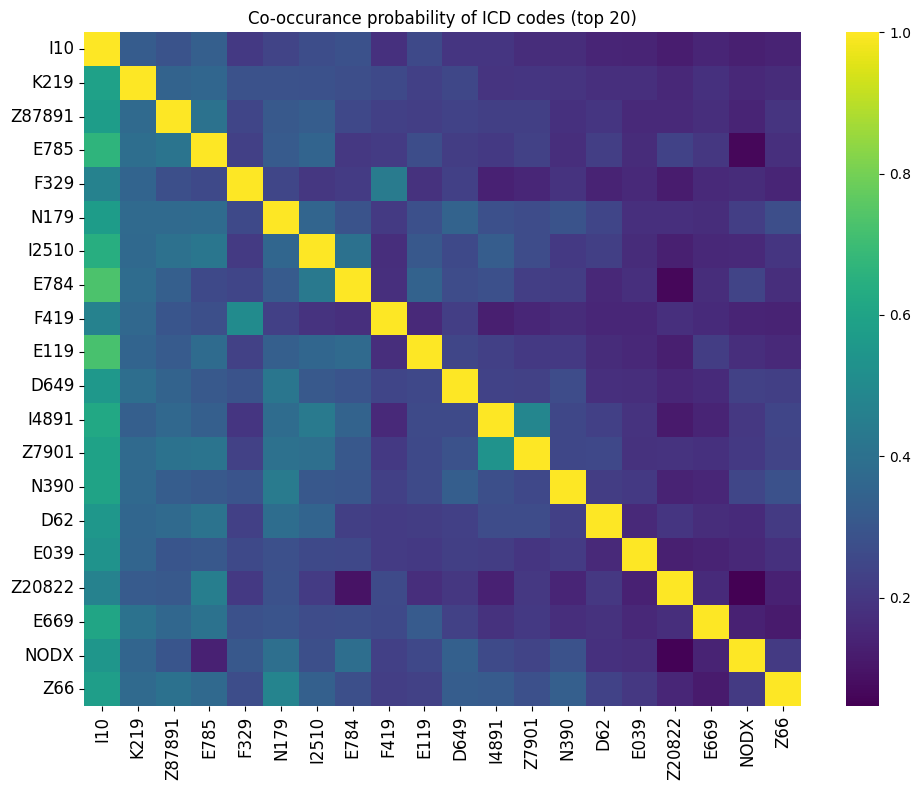

In [12]:
N = 20
diag_values = np.diag(fraction_df)
top_20_indices = np.argsort(diag_values)[::-1][:N]
top_icds = [idx2icd[i] for i in top_20_indices]


top_cond_df = cond_df.loc[top_icds, top_icds]

plt.figure(figsize=(10, 8))
sns.heatmap(top_cond_df, annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Co-occurance probability of ICD codes (top 20)")
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


TBA

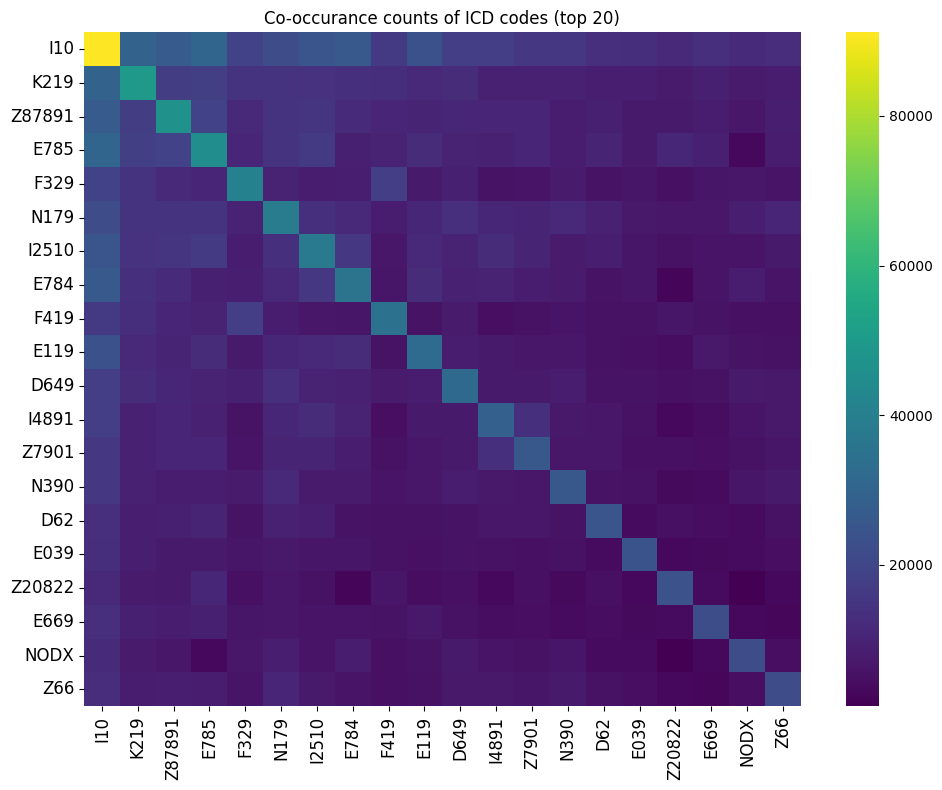

In [13]:
N = 20
diag_values = np.diag(fraction_df)
top_20_indices = np.argsort(diag_values)[::-1][:N]
top_icds = [idx2icd[i] for i in top_20_indices]


top_co_df = co_df.loc[top_icds, top_icds]

plt.figure(figsize=(10, 8))
sns.heatmap(top_co_df, annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Co-occurance counts of ICD codes (top 20)")
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

In [2]:
co_df = pd.read_csv("data/co_matrix_counts.csv")
fraction_df = pd.read_csv("data/co_matrix_fraction.csv") 
cond_df = pd.read_csv("data/co_matrix_conditional_prob.csv")

In [2]:
cond_df = pd.read_csv("data/co_matrix_conditional_prob.csv")

In [3]:
cond_df.head()

,Unnamed: 0,K766,R188,K740,B1920,J449,F319,F4310,Z87891,B1921,...,S61207A,S25891A,S62304B,T85111A,T85113A,T24011A,S85011A,O30093,V835XXA,O359XX2
0,K766,1.000000,0.452898,0.263773,0.196280,0.133556,0.042452,0.036012,0.369664,0.042929,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,R188,0.372280,1.000000,0.217212,0.121741,0.127426,0.029798,0.023133,0.354832,0.034699,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,K740,0.436292,0.437081,1.000000,0.345168,0.170809,0.051677,0.040237,0.351874,0.072978,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B1920,0.177562,0.133981,0.188781,1.000000,0.150378,0.137648,0.130097,0.282632,0.035599,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,J449,0.032411,0.037620,0.025061,0.040340,1.000000,0.046417,0.032411,0.491724,0.003125,...,0.0,0.000058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
mat   = co_df.values          # плотная матрица (N×N, int)
names = co_df.index.to_numpy()

# ставим 0 на диагональ (чтобы не захватывать i==j)
np.fill_diagonal(mat, 0)

# берём верхний треугольник без diag
triu_idx = np.triu_indices_from(mat, k=1)
vals = mat[triu_idx]

# получаем индексы 20 наибольших значений
top_k = 20
largest_idx = np.argpartition(vals, -top_k)[-top_k:]
order = largest_idx[np.argsort(vals[largest_idx])[::-1]]

# формируем список пар с именами и count
top_pairs = [
    (names[i], names[j], int(vals[idx]))
    for idx, i, j in zip(order, triu_idx[0][order], triu_idx[1][order])
]

top20_co = (
    pd.DataFrame(top_pairs, columns=["icd_i", "icd_j", "count"])
          .reset_index(drop=True)
)

top20_co.to_csv("data/top20_co.csv", index=False)
print(top20_co)


    icd_i  icd_j  count
0      61     62  91186
1      35     36  49543
2       7      8  46243
3      25     26  45431
4     133    134  40186
5      80     81  38389
6      88     89  37934
7     111    112  35258
8      37     38  35075
9      63     64  32249
10     55     56  31640
11     25     62  30291
12     35     62  29094
13     86     87  28276
14      7     62  26596
15     61    112  25799
16     47     48  25499
17    120    121  25402
18     61     89  24506
19    214    215  24328


In [ ]:
# import numpy as np
# import pandas as pd
# from pathlib import Path

# top_k = 20

# mat   = cond_df.values.copy()           
# names = cond_df.index.to_numpy()        

# np.fill_diagonal(mat, 0)                

# triu_idx = np.triu_indices_from(mat, k=1)
# vals = mat[triu_idx]                

# largest_idx = np.argpartition(vals, -top_k)[-top_k:]
# order       = largest_idx[np.argsort(vals[largest_idx])[::-1]]

# top_pairs = [
#     (names[i], names[j], float(vals[idx]))
#     for idx, i, j in zip(order, triu_idx[0][order], triu_idx[1][order])
# ]

# top20_cond = (
#     pd.DataFrame(top_pairs, columns=["icd_i", "icd_j", "p_j_given_i"])
#       .reset_index(drop=True)
# )

# top20_cond.to_csv("data/top20_cond.csv", index=False)

In [5]:
# читаем CSV сразу с индексом
cond_df = pd.read_csv("data/co_matrix_conditional_prob.csv", index_col=0)

# убедимся, что все оставшиеся колонки — числовые
cond_df = cond_df.astype(np.float32)      # теперь только float

# дальше идёт быстрый алгоритм top-k
mat   = cond_df.to_numpy(copy=False)      # OK: float32
names = cond_df.index.to_numpy()

np.fill_diagonal(mat, 0)

top_k = 20
heap  = []

for i in range(mat.shape[0] - 1):
    row = mat[i, i+1:]
    idx_top = np.argpartition(row, -top_k)[-top_k:]
    for j in idx_top:
        v = float(row[j])
        if len(heap) < top_k:
            heapq.heappush(heap, (v, i, i+1+j))
        else:
            heapq.heappushpop(heap, (v, i, i+1+j))

top_pairs = sorted(heap, reverse=True)
top20_cond = pd.DataFrame(
    [(names[i], names[j], v) for v, i, j in top_pairs],
    columns=["icd_i", "icd_j", "p_j_given_i"]
).reset_index(drop=True)

top20_cond.to_csv("data/top20_cond.csv", index=False)
print(top20_cond)


ValueError: kth(=-1) out of bounds (19)

In [ ]:
# co_long = co_df.stack().reset_index()
# co_long.columns = ['icd_i', 'icd_j', 'count']
# co_long = co_long[co_long['icd_i'] != co_long['icd_j']]
# top20_co = co_long.sort_values('count', ascending=False).head(20)

# top20_co.to_csv("data/top20_co.csv")


In [ ]:
# cond_long = cond_df.stack().reset_index()
# cond_long.columns = ['icd_i', 'icd_j', 'p_j_given_i']
# cond_long = cond_long[cond_long['icd_i'] != cond_long['icd_j']]
# top20_cond = cond_long.sort_values('p_j_given_i', ascending=False).head(20)

# top20_cond.to_csv("data/top20_cond.csv")

In [ ]:
def plot_heatmap(dataframe, value_col, title):
    pivot = dataframe.pivot(index='icd_i', columns='icd_j', values=value_col)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# абсолютные значения из co_df
plot_heatmap(top20_co, 'count', 'Top 20 Co-occurrence Counts (Patients with both ICDs)')

# условная вероятность 
plot_heatmap(top20_cond, 'p_j_given_i', 'Top 20 Conditional Probabilities P(j | i)')

# # 3. Lift (настоящая взаимосвязь)
# plot_heatmap(top20_lift, 'lift', 'Top 20 Lift Scores (Association Strength)')


In [ ]:
def plot_heatmap(dataframe, value_col, title):
    pivot = dataframe.pivot(index='icd_i', columns='icd_j', values=value_col)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_heatmap(top20_co, 'count', 'Top 20 Co-occurrence Counts (Patients with both ICDs)')

plot_heatmap(top20_cond, 'p_j_given_i', 'Top 20 Conditional Probabilities P(j | i)')

